# Probabilistic Programming 3: Hidden Markov modeling
## Monte Carlo sampling

In this notebook, we will be looking at forecasting a time-series. To be precise, we will implement a Hidden Markov Model using Turing.

### Preliminaries

- Goal 
  - Learn to apply Turing to a time-series data set.
- Materials        
  - Mandatory
    - These lecture notes.
  - Optional
    - [Tutorial on Bayesian HMM using Turing.jl](https://turing.ml/dev/tutorials/4-bayeshmm/)
    - [Probabilistic Programming notebook](https://github.com/bertdv/BMLIP/tree/master/lessons/notebooks/probprog/Probabilistic-Programming.ipynb)
    - [Cheatsheets: how does Julia differ from Matlab / Python](https://docs.julialang.org/en/v1/manual/noteworthy-differences/index.html).

In [3]:
# Package managing
using Pkg
Pkg.activate("workspace")
Pkg.instantiate();

using Logging; disable_logging(LogLevel(0))
using Distributions
using StatsPlots
using Turing
using MCMCChains
Turing.setadbackend(:forward_diff)
include("../scripts/pp-3.jl");

Activating environment at `~/Dropbox/Courses/tueindhoven/5SSD0 - Bayesian Machine Learning & Information Processing/BMLIP/lessons/notebooks/probprog/workspace/Project.toml`


### Data generation

In this problem setting, data is generated in the form of states over time. For example, proteins that fold into one of several functional configurations or machine translation, where one observes writing in one language and aims to infer writing in another language (both being finite sets of symbols). We don't have perfect measurement tools and have to assume measurement noise. 

We will generate a synthetic data set as follows: we pick an initial state and evolve the state using a fixed state transition matrix. Then we observe the state using a fixed observation probability, referred to as an _emission_ matrix. 

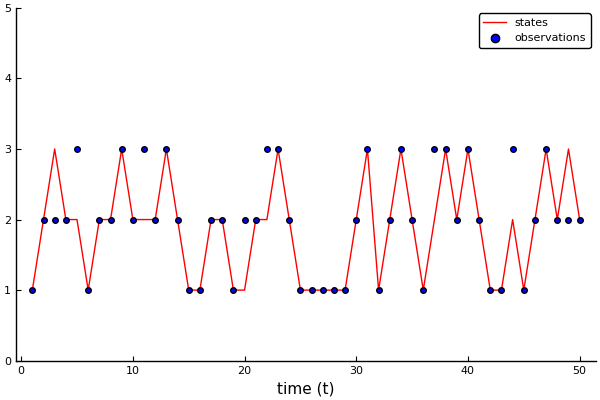

In [4]:
# There are 3 possible states and each variable is in one of those (one-hot encoding)
K = 3

# Length of time-series
T = 50

# Transition matrix of latent variables
transition = [0.3 0.6 0.1; 
              0.5 0.2 0.3; 
              0.2 0.7 0.1]

# Emission matrix for observed variables
emission = [0.9 0.1 0.0; 
            0.1 0.8 0.1; 
            0.0 0.2 0.8]

# Preallocate data arrays
states = Array{Int64,1}(undef, T)
observations = Array{Int64,1}(undef, T)

# Initial state
state_0 = 1

# Keep previous state in memory
state_tmin = state_0

# Generate data for entire time-series
for t = 1:T
    
    # Transition from previous state
    states[t] = rand(Categorical(transition[state_tmin, :]), 1)[1]
    
    # Emission of current state
    observations[t] = rand(Categorical(emission[states[t], :]), 1)[1]
    
    # Update previous state
    state_tmin = states[t]
    
end

# Visualization.
plot(1:T, states, color="red", label="states", ylim=(0, 5), grid=false)
scatter!(1:T, observations, color="blue", label="observations")
xlabel!("time (t)")

## Model Specification

The Hidden Markov model is a state-space model of the form:

$$\begin{align}
x_t \sim&\ \text{Cat}(A x_{t-1}) \\
y_t \sim&\ \text{Cat}(B x_t)
\end{align}$$

where $A$ is the state transition matrix and $B$ is the emission matrix. The states $x$ are indexed by time $t$, ranging from $0$ to $T$. The observations $y$ are indexed from $1$ to $T$. 

Again, we start simple and slowly improve the model.

### Model 1: estimate states

We will first assume we know the transition and emission matrices. Based on these, we purely want to estimate states from observations.

In [4]:
# Turing model definition.
@model HMM(y, K, A, B) = begin
    
    # Get observation length.
    N = length(y)

    # State sequence.
    x = Vector{Int}(undef, N+1)

    # Define initial state
    x[1] ~ Categorical(ones(K,)./K)

    # Loop over entire sequence
    for t = 2:N+1
        
        # State transition     
        x[t] ~ Categorical(A[x[t-1], :])
        
        # Observation emission
        y[t-1] ~ Categorical(B[x[t], :])
    end
end;

# Call instance of the model
model1 = HMM(observations, K, transition, emission);

The Categorical distribution is a known parametric distribution, which we can marginalize. It is therefore suited to Gibbs sampling.

In [5]:
# Length of chain
len_chain = 500

# Define sampler
sampler1 = Gibbs(PG(50, :x))

# Call sampler
chain1 = sample(model1, sampler1, len_chain);

Progress: 100%|█████████████████████████████████████████| Time: 0:02:49


Let's inspect the chain again. Note that $x$ is an array of $T$ latent variables, so this is a long table.

In [6]:
chain1[:x]

Object of type Chains, with data of type 500×51×1 Array{Float64,3}

Iterations        = 1:500
Thinning interval = 1
Chains            = 1
Samples per chain = 500
parameters        = x[1], x[2], x[3], x[4], x[5], x[6], x[7], x[8], x[9], x[10], x[11], x[12], x[13], x[14], x[15], x[16], x[17], x[18], x[19], x[20], x[21], x[22], x[23], x[24], x[25], x[26], x[27], x[28], x[29], x[30], x[31], x[32], x[33], x[34], x[35], x[36], x[37], x[38], x[39], x[40], x[41], x[42], x[43], x[44], x[45], x[46], x[47], x[48], x[49], x[50], x[51]

2-element Array{ChainDataFrame,1}

Summary Statistics
. Omitted printing of 1 columns
│ Row │ parameters │ mean    │ std      │ naive_se  │ mcse      │ ess     │
│     │ Symbol     │ Float64 │ Float64  │ Float64   │ Float64   │ Any     │
├─────┼────────────┼─────────┼──────────┼───────────┼───────────┼─────────┤
│ 1   │ x[1]       │ 1.824   │ 0.725311 │ 0.0324369 │ 0.0283901 │ 76.0451 │
│ 2   │ x[2]       │ 1.338   │ 0.481893 │ 0.0215509 │ 0.10244   │ 65.3335 │
│ 3 

Since the state space is discrete, we cannot take the sample average of the chain to obtain estimates. The sample average is continuous, after all. To obtain discrete estimates, we take the median of the chain.

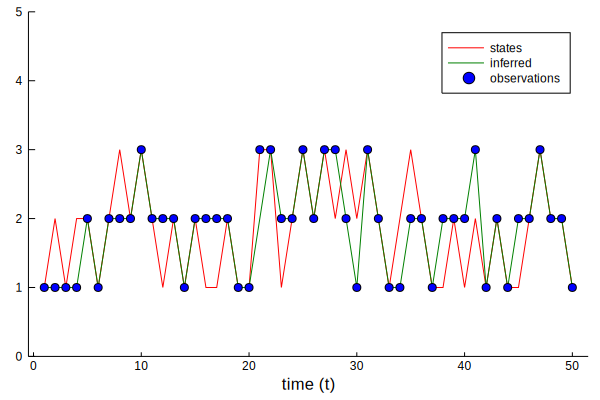

In [7]:
# Extract mean of chain
x_hat = median_chain(chain1, :x)

# Visualization
plot(1:T, states[2:end], color="red", label="states", ylim=(0, 5), grid=false)
plot!(1:T, x_hat[2:end], color="green", label="inferred")
scatter!(1:T, observations, color="blue", label="observations")
xlabel!("time (t)")

### Model 2: transition matrix estimation

At the moment, we assume we know how the states evolve over time. This is not an unreasonable assumption; in protein folding we know exactly _how_ the protein changes state, i.e. through the signaling of another molecule, and we know the concentration of signal molecules. However, in other applications we do not necessarily know the transition matrix. 

We can estimate the transition matrix by letting the coefficients be latent variables and posing a prior.

In [8]:
# Turing model definition.
@model HMM(y, K, B) = begin
    
    # Get observation length.
    N = length(y)

    # State sequence.
    x = Vector{Int}(undef, N+1)

    # Define initial state
    x[1] ~ Categorical(ones(K,)./K)
    
    # Define variables for transition matrix
    A = Vector{Vector}(undef, K)
    
    # Each row represents state transition probabilities and should sum to one
    for k = 1:K
        A[k] ~ Dirichlet(ones(K))
    end

    # Loop over entire sequence
    for t = 2:N+1
        
        # State transition     
        x[t] ~ Categorical(A[x[t-1]])
        
        # Observation emission
        y[t-1] ~ Categorical(B[x[t], :])
        end
end;

# Call instance of the model
model2 = HMM(observations, K, emission);

We will extend the current sampler with a Hamiltonian MC for the transition matrix.

In [9]:
# Length of chain
len_chain = 500

# Define sampler
sampler2 = Gibbs(PG(50, :x), HMC(0.1, 5, :A))

# Call sampler
chain2 = sample(model2, sampler2, len_chain);

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC /home/wmkouw/.julia/packages/AdvancedHMC/Sn9Ek/src/hamiltonian.jl:44
Progress: 100%|█████████████████████████████████████████| Time: 0:02:24


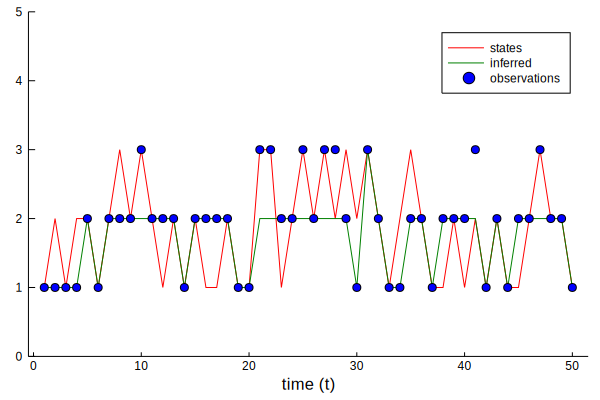

In [10]:
# Extract mean of chain
x_hat = median_chain(chain2, :x)

# Visualization
plot(1:T, states[2:end], color="red", label="states", ylim=(0, 5), grid=false)
plot!(1:T, x_hat[2:end], color="green", label="inferred")
scatter!(1:T, observations, color="blue", label="observations")
xlabel!("time (t)")

Let's visualize the estimated transition matrix.

### Model 3: states, transition and emission

We can extend the model further to also estimate the emission matrix. 

In [12]:
include("../scripts/pp-3.jl")

# Turing model definition.
@model HMM(y, K) = begin
    
    # Get observation length.
    N = length(y)

    # State sequence.
    x = Vector{Int}(undef, N+1)

    # Define initial state
    x[1] ~ Categorical(ones(K,)./K)
    
    # Define variables for transition and emission matrices
    A = Vector{Vector}(undef, K)
    B = Vector{Vector}(undef, K)
    
    # Each row should sum to one
    for k = 1:K
        A[k] ~ Dirichlet(ones(K))
        B[k] ~ Dirichlet(10*one_hot(k,K) .+ 1)
    end

    # Loop over entire sequence
    for t = 2:N+1
        
        # State transition     
        x[t] ~ Categorical(A[x[t-1]])
        
        # Observation emission
        y[t-1] ~ Categorical(B[x[t]])
        
    end
end;

# Call instance of the model
model3 = HMM(observations, K);

In [13]:
# Length of chain
len_chain = 500

# Define sampler
sampler3 = Gibbs(PG(50, :x), HMC(0.001, 2, :A, :B))

# Call sampler
chain3 = sample(model3, sampler3, len_chain);

Progress: 100%|█████████████████████████████████████████| Time: 0:03:55


In [14]:
describe(chain3)

2-element Array{ChainDataFrame,1}

Summary Statistics
. Omitted printing of 2 columns
│ Row │ parameters │ mean      │ std         │ naive_se    │ mcse        │
│     │ Symbol     │ Float64   │ Float64     │ Float64     │ Float64     │
├─────┼────────────┼───────────┼─────────────┼─────────────┼─────────────┤
│ 1   │ A[1][1]    │ 0.197127  │ 0.00172661  │ 7.72165e-5  │ 0.000688032 │
│ 2   │ A[1][2]    │ 0.325461  │ 0.00210686  │ 9.42217e-5  │ 0.000587025 │
│ 3   │ A[1][3]    │ 0.477411  │ 0.00262546  │ 0.000117414 │ 0.00103721  │
│ 4   │ A[2][1]    │ 0.318135  │ 0.00241757  │ 0.000108117 │ 0.000600363 │
│ 5   │ A[2][2]    │ 0.398122  │ 0.00187369  │ 8.37939e-5  │ 0.000634349 │
│ 6   │ A[2][3]    │ 0.283743  │ 0.00166463  │ 7.44446e-5  │ 0.000522727 │
│ 7   │ A[3][1]    │ 0.454082  │ 0.00202041  │ 9.03553e-5  │ 0.000768504 │
│ 8   │ A[3][2]    │ 0.454258  │ 0.00155773  │ 6.96638e-5  │ 0.000583117 │
│ 9   │ A[3][3]    │ 0.0916608 │ 0.00120369  │ 5.38306e-5  │ 0.000499591 │
│ 10  │ B[1][1

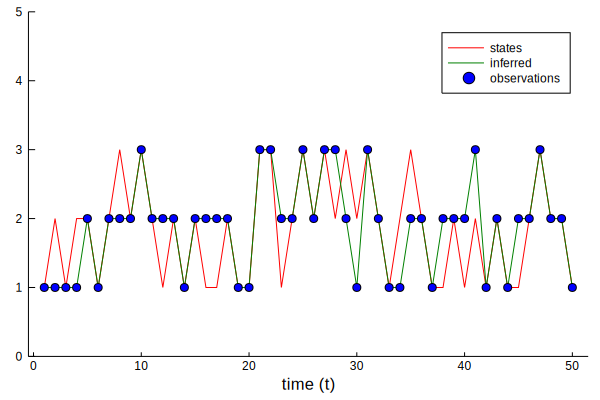

In [15]:
# Extract mean of chain
x_hat = median_chain(chain3, :x)

# Visualization
plot(1:T, states[2:end], color="red", label="states", ylim=(0, 5), grid=false)
plot!(1:T, x_hat[2:end], color="green", label="inferred")
scatter!(1:T, observations, color="blue", label="observations")
xlabel!("time (t)")

### Assignment: priors

Note that it becomes harder to identify whether an observation was noisily generated from one state or precisely generated from another state. This is another advantage of the Bayesian formalism: the prior distribution can favor certain solutions over others. If we have some idea of how noisy the sensor is, but not exact enough to fix the emission matrix to particular values, then we can still favor solutions certain solutions. 

Play around with the prior parameters of the state transition and emission matrices. How does the state estimation depend on the priors?

In [17]:
### Your code here

### Optional assignment: continuous observations

We can extend the problem setting to one where the states are discrete, but the observations are continuous. Think for example of speech recognition. There are a finite set of syllables that can be uttered, but each person does this in a slightly different way. 

Given the following data set, can you change the model such that it infers the discrete states from continuous observations? In other words, that it follows the following formulation:

$$\begin{align} 
x_t \sim&\ \text{Cat}(A x_{t-1}) \\
y_t \sim&\ \mathcal{N}(x_t, \sigma)
\end{align}$$


In [18]:
### Your code here